In [1]:
%matplotlib inline

In [2]:
from fenics import *
from fenics_adjoint import *
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import dolfin.fem.norms as norms
from collections import OrderedDict
import time


# Local imports
import state_eq as se
import adjoint_eq as ae

In [3]:
a0 = 1.0
a1 = 1e-01
a_tol = 1e-14
a_exp = Expression('sqrt(pow(x[0] - 0.3, 2) + pow(x[1] - 0.4, 2)) <= 0.2 + tol ? a0 : a1', element=element, a0=a0, a1=a1, tol=a_tol)
a_const = interpolate(a_exp, V)
rho = 0.0
lambda_ = 1.4
alpha = 1e-05
r = project(Expression("0.01*sqrt(pow(x[0],2) + pow(x[1], 2))", element=element), V)

params = {
    "rho": rho,
    "lambda_": lambda_,
    "r": r,
    "alpha": alpha,
    "a": a_const
}

NameError: name 'element' is not defined

In [4]:
# --- Define mesh and function space ---

# Set time parameters
T = 4.0
num_steps = 100
dt = Constant(T/num_steps)

# Define function space
nx = 50
ny = 50
mesh = UnitSquareMesh(nx,ny)

V = FunctionSpace(mesh, "CG", 1)
W = FunctionSpace(mesh, "CG", 1)

u_n = Function(V, name="Solution")
q = Function(W, name="Control")
u = Function(V)
phi = TestFunction(V)

ctrls = OrderedDict()
t = 0.0
ctrls[t] = Function(V)
for i in range(num_steps):
    t += float(dt)
    ctrls[t] = Function(V)

In [5]:
element = FiniteElement("CG", triangle, 1)

In [6]:
# --- Do one solve of the State Equation and assemble Cost Functional ---

# Params
"""a_const = params["a"]
rho = params["rho"]
lambda_ = params["lambda_"]
r = params["r"]
alpha = params["alpha"]"""

# Params to replicate results from paper
a0 = 1.0
a1 = 1e-01
a_tol = 1e-14
a_exp = Expression('sqrt(pow(x[0] - 0.3, 2) + pow(x[1] - 0.4, 2)) <= 0.2 + tol ? a0 : a1', element=element, a0=a0, a1=a1, tol=a_tol)
a_const = interpolate(a_exp, V)
rho = 0.0
lambda_ = 1.4
alpha = 1e-05
r = project(Expression("0.01*sqrt(pow(x[0],2) + pow(x[1], 2))", element=element), V)

# Box constraints
q_min = 0.0
q_max = 1.0

# State
u_0 = Constant(0.7)  #Expression('b*exp(-a*(pow(x[0]-0.25, 2) + pow(x[1]-0.25, 2)))', element=element, a=10, b=20)
u_n.assign(project(u_0, V))

# Variational form
a = u*phi*dx + dt*(inner(grad(u), grad(phi))*dx + u_n*u*phi*dx - a_const*u*phi*dx + q*u*phi*dx)
l = u_n*phi*dx

F = a - l


t = 0.0
q.assign(ctrls[t])
f = float(np.exp(-1*rho*t))
j = 0.5*float(dt)*f*assemble(q*(r-u_n)*dx) + 0.5*float(dt)*alpha*assemble(inner(q, q)*dx)/2

t = float(dt)
for i in range(num_steps):
    q.assign(ctrls[t])
    
    solve(F == 0, u)
    u_n.assign(u)
    
    if t > T - float(dt):
        weight = 0.5
    else:
        weight = 1
        
    f = float(np.exp(-1*rho*t))
    j += weight*float(dt)*f*assemble(q*(r-u_n)*dx) + weight*float(dt)*alpha*assemble(q*q*dx)/2

    t += float(dt)
    
j += -1*lambda_*assemble(u_n*dx)

In [7]:
t

4.040000000000003

In [8]:
m = [Control(c) for c in ctrls.values()]
lb = [q_min for i in range(len(m))]
ub = [q_max for i in range(len(m))]
bounds = [lb, ub]

rf = ReducedFunctional(j, m)

print("-"*6 + " Ready to optimize " + "-"*6)

start_time = time.time()
opt_ctrls = minimize(rf, bounds=bounds, options={"maxiter": 50})
end_time = time.time()
delta = end_time - start_time

print("Optimization terminated")
print("Time taken to find local optimum: {} s".format(round(delta, 2)))

------ Ready to optimize ------
Calling FFC just-in-time (JIT) compiler, this may take some time.
Optimization terminated
Time taken to find local optimum: 21.07 s


In [9]:
len(opt_ctrls), t, T

(101, 4.040000000000003, 4.0)

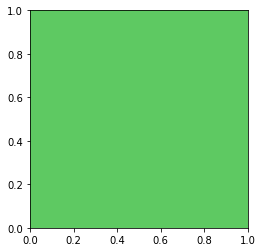

In [10]:
plot(opt_ctrls[10])

In [11]:
for indx in [5, 44, 50, 78, 99]:
    print(opt_ctrls[indx].vector().min(), opt_ctrls[indx].vector().max())

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


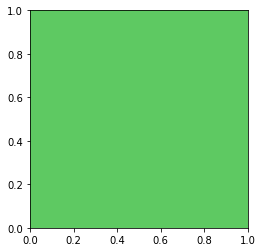

In [12]:
plot(opt_ctrls[0])

In [13]:
print(t)

4.040000000000003


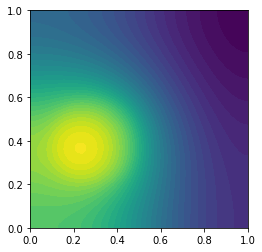

In [14]:
plot(u_n)

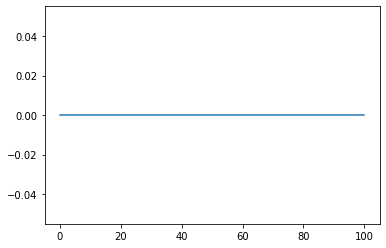

In [15]:
x = [c((0.25, 0.25)) for c in opt_ctrls]
plt.plot(x)
plt.show()

In [ ]:
U = se.solve_state_eq(u_0, opt_ctrls, V, T, num_steps, params)

In [ ]:
se.plot_states_and_control(U, opt_ctrls, T, num_steps, num_plots=5)

In [ ]:
plot(a_const)

In [ ]:
plot(interpolate(a_exp, V))